In [1]:
from classical import XYModel
import torch
import time
import gc
import matplotlib.pyplot as plt

In [2]:
L = 32 # Lattice size
T_start = 0.1 # Start temperature
T_end = 2.0 # End temperature
precision = 0.05 # Temperature precision
device = "cuda:0"
T = torch.linspace(T_start, T_end, int((T_end-T_start)//precision)+1, device=device)
ensemble_number = 3000 # Number of samples
n_chains = 30 # Number of parallel chains. Suggested: 10~50
pt_interval = 2 # Parallel tempering interval. Suggested: 1~5
pt_prob = 0.1 # Parallel tempering probability 0.1~0.5
tau_pt = pt_interval / pt_prob # Autocorrelation time for parallel tempering
factor_therm = 15 # 10~50
factor_decorrelate = 2 # 1~10
tau = L**2 # Autocorrelation time
tau_eff = (tau_pt * tau) / (tau_pt + tau) # Effective Autocorrelation time
n_therm =  int(factor_therm * tau) # Number of thermalization sweeps
decorrelate = int(factor_decorrelate * tau_eff) # Number of decorrelation sweeps
n_sweeps = int(ensemble_number / n_chains) * decorrelate # Number of sweeps

print(f"Lattice size: {L}")
print(f"Temperature range: {T_start} to {T_end}")
print(f"Number of temperatures: {len(T)}")
print(f"Number of samples per temperature: {ensemble_number}")
print(f"Number of sweeps: {n_sweeps}")
print(f"Number of thermalization sweeps: {n_therm}")
print(f"Number of chains: {n_chains}")
print(f"Number of decorrelate: {decorrelate}")

sampler_xy = XYModel(
    L=L,
    T=T,
    n_chains=n_chains,
    # adaptive=True,
    # target_acceptance=0.6,
    # adapt_rate=0.1,
    device=torch.device(device),
    use_amp=True,
    pt_enabled=True, # Suggestions: Parallel tempering enabled for better sampling.
    )

start = time.time()
samples_xy = sampler_xy(n_sweeps=n_sweeps, n_therm=n_therm, decorrelate=decorrelate, pt_interval=pt_interval)
end = time.time()
print(f"Elapsed time: {end - start:.2f} s")

Lattice size: 32
Temperature range: 0.1 to 2.0
Number of temperatures: 38
Number of samples per temperature: 3000
Number of sweeps: 3900
Number of thermalization sweeps: 15360
Number of chains: 30
Number of decorrelate: 39
Initialized MonteCarloSampler on device: cuda:0
 L=32, BatchSize=38, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Starting simulation: 15360 thermalization sweeps, 3900 production sweeps.
Thermalization phase...
Production phase...
Simulation finished. Collected 3000 samples.
Elapsed time: 24.48 s


Samples shape: torch.Size([38, 3000, 32, 32])


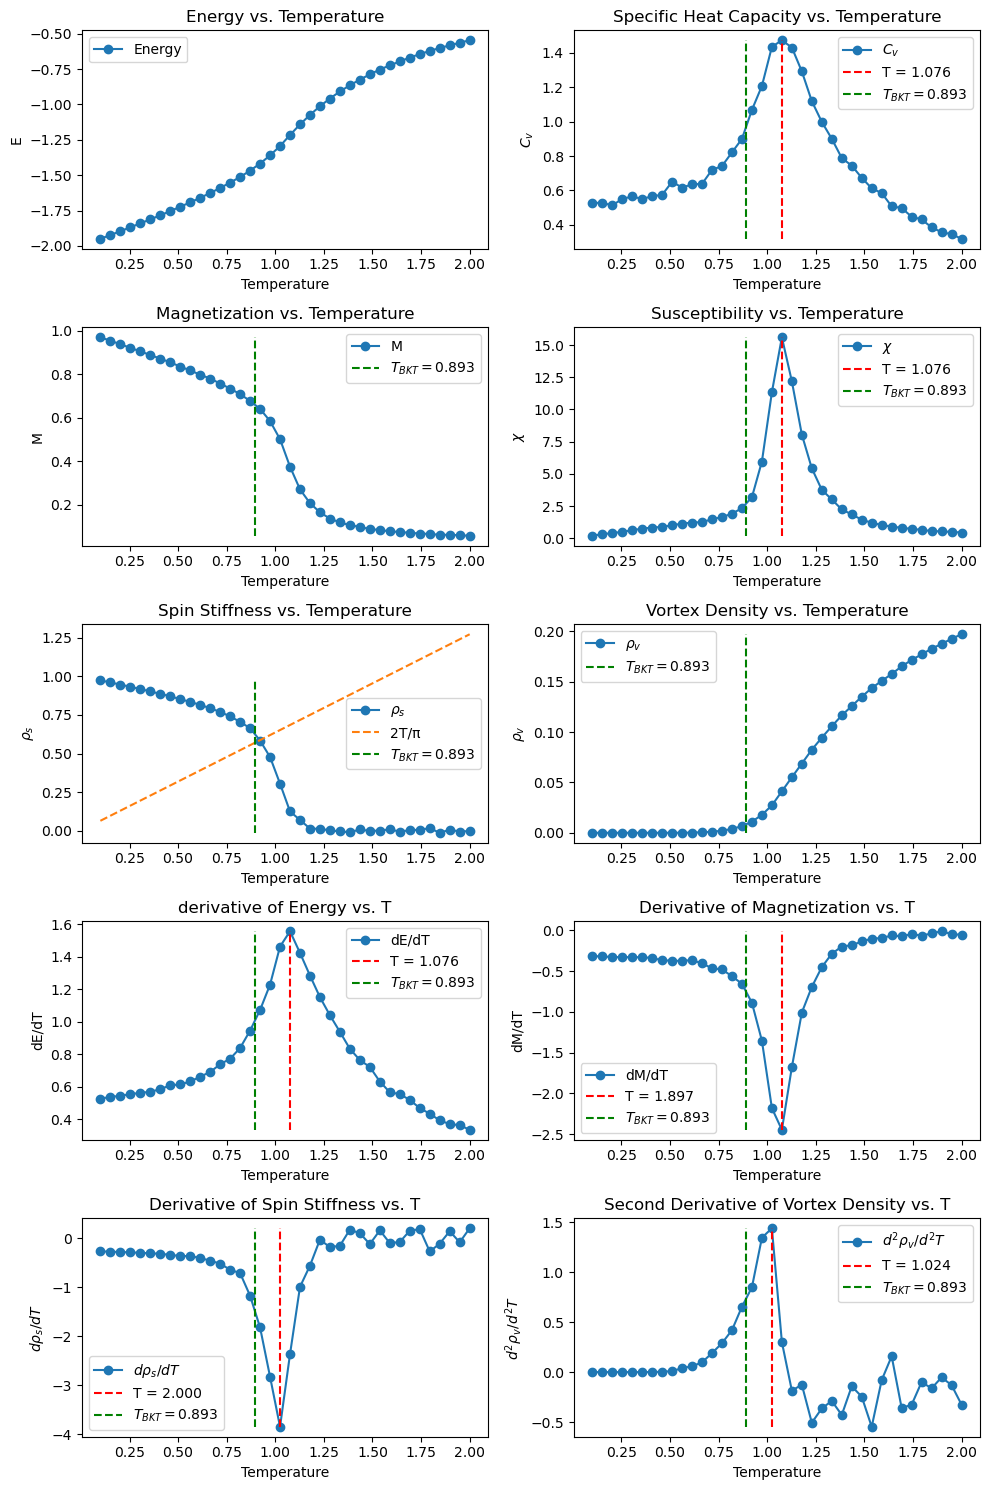

In [3]:
print(f"Samples shape: {samples_xy.shape}")

sampler_xy.spins = samples_xy

energy_xy = sampler_xy.compute_average_energy()
energy_xy_derivative = sampler_xy.high_precision_derivative(
    seq=energy_xy, spacing=precision).cpu().numpy()
energy_xy = energy_xy.cpu().numpy()
capacity_xy = sampler_xy.compute_specific_heat_capacity().cpu().numpy()
stiffness_xy = sampler_xy.compute_spin_stiffness()
stiffness_xy_derivative = sampler_xy.high_precision_derivative(
    seq=stiffness_xy, spacing=precision).cpu().numpy()
stiffness_xy = stiffness_xy.cpu().numpy()
magnetization_xy = sampler_xy.compute_magnetization()
magnetization_xy_derivative = sampler_xy.high_precision_derivative(
    seq=magnetization_xy, spacing=precision).cpu().numpy()
magnetization_xy = magnetization_xy.cpu().numpy()
susceptibility_xy = sampler_xy.compute_susceptibility().cpu().numpy()
vortex_density_xy = sampler_xy.compute_vortex_density(low_memory=False)
vortex_density_xy_derivative = sampler_xy.high_precision_derivative(
    seq=vortex_density_xy, spacing=precision)
vortex_density_xy_derivative2 = sampler_xy.high_precision_derivative(
    seq=vortex_density_xy_derivative, spacing=precision).cpu().numpy()
vortex_density_xy = vortex_density_xy.cpu().numpy()
temp = sampler_xy.T.cpu().numpy()

plt.figure(figsize=(10, 15))
plt.subplot(521)
plt.plot(temp, energy_xy, label='Energy', marker='o')
plt.xlabel('Temperature')
plt.ylabel('E')
plt.title('Energy vs. Temperature')
plt.legend()
plt.subplot(522)
plt.plot(temp, capacity_xy, label=r'$C_v$', marker='o')
plt.vlines(temp[capacity_xy.argmax()], capacity_xy.min(), capacity_xy.max(),
           color='red', linestyle='--', label='T = %.3f' % temp[capacity_xy.argmax()])
plt.vlines(0.893, capacity_xy.min(), capacity_xy.max(),
           color='green', linestyle='--', label=r'$T_{BKT} = 0.893$')
plt.xlabel('Temperature')
plt.ylabel(r'$C_v$')
plt.title('Specific Heat Capacity vs. Temperature')
plt.legend()
plt.subplot(523)
plt.plot(temp, magnetization_xy, label='M', marker='o')
plt.vlines(0.893, magnetization_xy.min(), magnetization_xy.max(),
           color='green', linestyle='--', label=r'$T_{BKT} = 0.893$')
plt.xlabel('Temperature')
plt.ylabel('M')
plt.title('Magnetization vs. Temperature')
plt.legend()
plt.subplot(524)
plt.plot(temp, susceptibility_xy, label=r'$\chi$', marker='o')
plt.vlines(temp[susceptibility_xy.argmax()], susceptibility_xy.min(), susceptibility_xy.max(),
              color='red', linestyle='--', label='T = %.3f' % temp[susceptibility_xy.argmax()])
plt.vlines(0.893, susceptibility_xy.min(), susceptibility_xy.max(),
           color='green', linestyle='--', label=r'$T_{BKT} = 0.893$')
plt.xlabel('Temperature')
plt.ylabel(r'$\chi$')
plt.title('Susceptibility vs. Temperature')
plt.legend()
plt.subplot(525)
plt.plot(temp, stiffness_xy, label=r'$\rho_{s}$', marker='o')
plt.plot(temp, list(map(lambda x: 2 * x / torch.pi, temp)), label='2T/π', linestyle='--')
plt.vlines(0.893, stiffness_xy.min(), stiffness_xy.max(),
           color='green', linestyle='--', label=r'$T_{BKT} = 0.893$')
plt.xlabel('Temperature')
plt.ylabel(r'$\rho_{s}$')
plt.title('Spin Stiffness vs. Temperature')
plt.legend()
plt.subplot(526)
plt.plot(temp, vortex_density_xy, label=r'$ρ_v$', marker='o')
plt.vlines(0.893, vortex_density_xy.min(), vortex_density_xy.max(),
           color='green', linestyle='--', label=r'$T_{BKT} = 0.893$')
plt.xlabel('Temperature')
plt.ylabel(r'$ρ_v$')
plt.title('Vortex Density vs. Temperature')
plt.legend()
plt.subplot(527)
plt.plot(temp, energy_xy_derivative, label='dE/dT', marker='o')
plt.vlines(temp[energy_xy_derivative.argmax()], energy_xy_derivative.min(), energy_xy_derivative.max(),
              color='red', linestyle='--', label='T = %.3f' % temp[energy_xy_derivative.argmax()])
plt.vlines(0.893, energy_xy_derivative.min(), energy_xy_derivative.max(),
           color='green', linestyle='--', label=r'$T_{BKT} = 0.893$')
plt.xlabel('Temperature')
plt.ylabel('dE/dT')
plt.title('derivative of Energy vs. T')
plt.legend()
plt.subplot(528)
plt.plot(temp, magnetization_xy_derivative, label='dM/dT', marker='o')
plt.vlines(temp[magnetization_xy_derivative.argmin()], magnetization_xy_derivative.min(), magnetization_xy_derivative.max(),
                color='red', linestyle='--', label='T = %.3f' % temp[magnetization_xy_derivative.argmax()])
plt.vlines(0.893, magnetization_xy_derivative.min(), magnetization_xy_derivative.max(),
           color='green', linestyle='--', label=r'$T_{BKT} = 0.893$')
plt.xlabel('Temperature')
plt.ylabel('dM/dT')
plt.title('Derivative of Magnetization vs. T')
plt.legend()
plt.subplot(529)
plt.plot(temp, stiffness_xy_derivative, label=r'$dρ_s/dT$', marker='o')
plt.vlines(temp[stiffness_xy_derivative.argmin()], stiffness_xy_derivative.min(), stiffness_xy_derivative.max(),
                color='red', linestyle='--', label='T = %.3f' % temp[stiffness_xy_derivative.argmax()])
plt.vlines(0.893, stiffness_xy_derivative.min(), stiffness_xy_derivative.max(),
           color='green', linestyle='--', label=r'$T_{BKT} = 0.893$')
plt.xlabel('Temperature')
plt.ylabel(r'$dρ_s/dT$')
plt.title('Derivative of Spin Stiffness vs. T')
plt.legend()
plt.subplot(5, 2, 10)
plt.plot(temp, vortex_density_xy_derivative2, label=r'$d^2ρ_v/d^2T$', marker='o')
plt.vlines(temp[vortex_density_xy_derivative2.argmax()], vortex_density_xy_derivative2.min(), vortex_density_xy_derivative2.max(),
                color='red', linestyle='--', label='T = %.3f' % temp[vortex_density_xy_derivative2.argmax()])
plt.vlines(0.893, vortex_density_xy_derivative2.min(), vortex_density_xy_derivative2.max(),
           color='green', linestyle='--', label=r'$T_{BKT} = 0.893$')
plt.xlabel('Temperature')
plt.ylabel(r'$d^2ρ_v/d^2T$')
plt.title('Second Derivative of Vortex Density vs. T')
plt.legend()
plt.tight_layout()
plt.show()
torch.cuda.empty_cache()

In [4]:
del sampler_xy, samples_xy, energy_xy, capacity_xy, stiffness_xy, magnetization_xy, susceptibility_xy, vortex_density_xy,\
    temp, vortex_density_xy_derivative, vortex_density_xy_derivative2, energy_xy_derivative,\
    stiffness_xy_derivative, magnetization_xy_derivative
del n_sweeps, n_therm, decorrelate, pt_interval, pt_prob, tau_pt, tau_eff
del factor_therm, factor_decorrelate, ensemble_number, n_chains, precision, T_start, T_end, L
del device, T
gc.collect()
torch.cuda.empty_cache()